<a href="https://colab.research.google.com/github/tranhoangnguyen03/DataProjects/blob/master/Demo_OpenStreetMap_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, IPython
os.system("apt-get install -qq curl g++ make; curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz")
os.chdir('spatialindex-src-1.8.5')
os.system("./configure; make; make install; pip install rtree ;ldconfig")
os.chdir('/content')
os.system('apt-get update; apt-get install -y libproj-dev proj-data proj-bin libgeos-dev libspatialindex-dev')
os.system('pip install pysal cython cartopy geoplot geopandas osmnx coverage coveralls folium pytest scikit-learn scipy sphinx twine  descartes Shapely')
#os.system("wget -O /usr/local/lib/python3.6/dist-packages/osmnx/footprints.py https://raw.githubusercontent.com/gboeing/osmnx/master/osmnx/footprints.py")
#os.system("wget -O /usr/local/lib/python3.6/dist-packages/osmnx/geo_utils.py https://raw.githubusercontent.com/gboeing/osmnx/master/osmnx/geo_utils.py")
#os.system("wget -O /usr/local/lib/python3.6/dist-packages/osmnx/geo_utils.py https://raw.githubusercontent.com/gboeing/osmnx/master/osmnx/osm_content_handler.py")
import networkx as nx
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

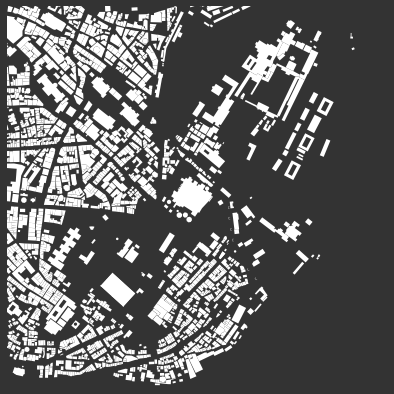

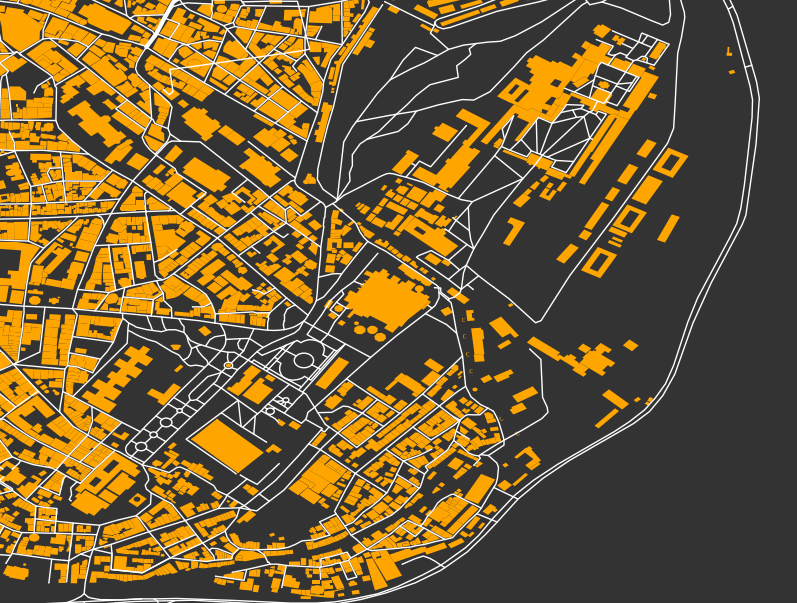

In [2]:
#@title Centered on Hagia Sophia (41.008469, 28.980261)
point = (41.008469, 28.980261) # Hagia Sophia
Area_in_KmSqur = 2 #@param {type:"slider", min:1, max:15, step:1}
dist = int(np.sqrt(Area_in_KmSqur*1000000)/2) # distance from center to edges of box

gdf = ox.footprints.footprints_from_point(point=point, distance=dist)
gdf_proj = ox.project_gdf(gdf)
bbox = ox.bbox_from_point(point=point, distance=dist, project_utm=True)
fig, ax = ox.footprints.plot_footprints(gdf_proj, bgcolor='#333333', color='w', figsize=(7,7), bbox=bbox, show=True)
plt.show()

def make_plot(place, point, dist, gdf, network_type='drive', bldg_color='orange', dpi=100, default_width=4, street_widths=None):
  fig, ax = ox.plot_figure_ground(point=point, dist=dist, network_type=network_type, default_width=default_width, street_widths=street_widths, save=False, show=False, close=True)
  fig, ax = ox.footprints.plot_footprints(gdf, fig=fig, ax=ax, color=bldg_color, set_bounds=False, save=True, show=False, close=True, filename=place, dpi=dpi)
  return f'images/{place}.png'

path = make_plot(place = 'Hagia_Sophia',point = (41.008469, 28.980261),dist = dist, gdf=gdf, network_type='all', default_width=1, street_widths={'secondary':3})
Image(path, height=600, width=600)

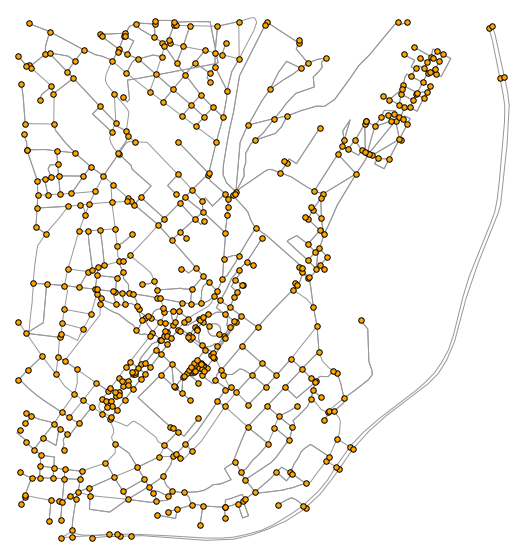

NumNodes:589,
NumEdges:1532


In [4]:
# retrieve map data as a graph of nodes and edges
G = ox.core.graph_from_point(center_point=point, distance = dist)
fig, ax = ox.plot_graph(G, fig_height=10, node_color='orange', node_size=30, node_zorder=2, node_edgecolor='k')
plt.show()
print(f'NumNodes:{G.number_of_nodes()},\nNumEdges:{G.number_of_edges()}')

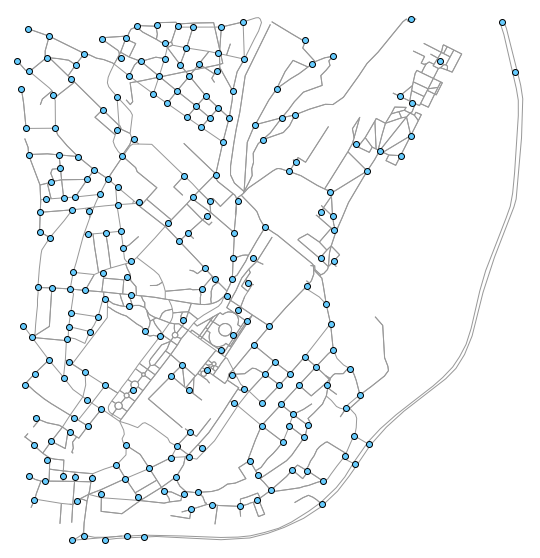

NumNodes:589,
NumEdges:1532


In [5]:
# clean up the intersections and extract their xy coords
G = ox.project_graph(G)
intersections = ox.clean_intersections(G, tolerance=15, dead_ends=False)
points = np.array([point.xy for point in intersections])

# plot the cleaned-up intersections
fig, ax = ox.plot_graph(G, fig_height=10, show=False, close=False, node_alpha=0)
ax.scatter(x=points[:,0], y=points[:,1], zorder=2, color='#66ccff', edgecolors='k')
plt.show()
print(f'NumNodes:{G.number_of_nodes()},\nNumEdges:{G.number_of_edges()}')

Columns in Nodes: ['y', 'x', 'osmid', 'highway', 'lon', 'lat', 'geometry']
Columns in Edges: ['u', 'v', 'key', 'osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry', 'access', 'width', 'tunnel', 'service', 'maxspeed', 'bridge']
Point 1: (666112.5728133727, 4541967.245127531)
Point 2: (665984.6927344346, 4541703.157169299)


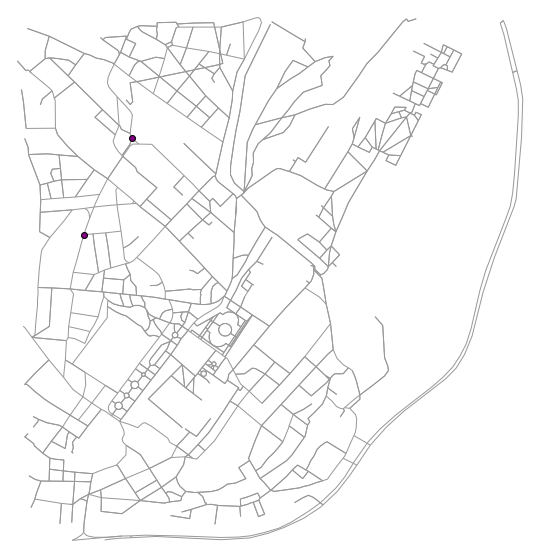

In [30]:
nodes_df, edges_df= ox.graph_to_gdfs(G)
print(f'Columns in Nodes: {list(nodes_df.columns)}\nColumns in Edges: {list(edges_df.columns)}')
# select two random points
indexes = np.random.choice(np.arange(len(nodes_df)),2)
point_1 = (nodes_df.iloc[indexes[0]]['x'],nodes_df.iloc[indexes[0]]['y'])
point_2 = (nodes_df.iloc[indexes[1]]['x'],nodes_df.iloc[indexes[1]]['y'])
print(f'Point 1: {point_1}\nPoint 2: {point_2}')

# visualize the two points
fig, ax = ox.plot_graph(G, fig_height=10, show=False, close=False, node_alpha=0)
ax.scatter(x=nodes_df.iloc[indexes]['x'].values, 
           y=nodes_df.iloc[indexes]['y'].values, zorder=2, color='purple', edgecolors='k')
plt.show()

Distance between Point 1 and Point 2 = 297 meters


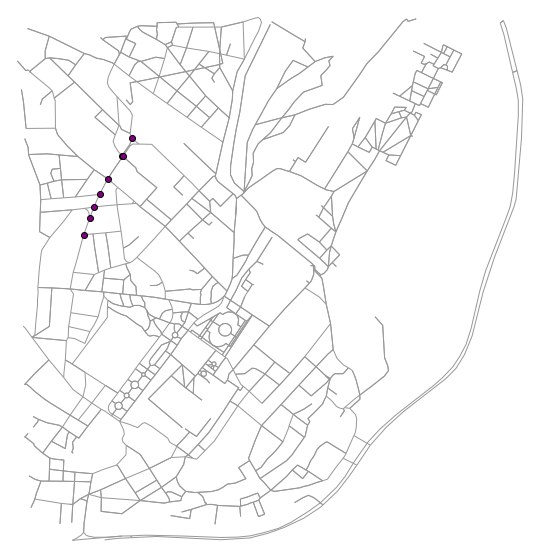

In [31]:
### shortest path distance
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
#orig_node = ox.get_nearest_node(G, point_1)
#target_node = ox.get_nearest_node(G, point_2)
length = nx.shortest_path_length(G, source=nodes_df.iloc[indexes[0]].osmid, target=nodes_df.iloc[indexes[1]].osmid, weight='length')
print(f'Distance between Point 1 and Point 2 = {int(length)} meters') 

path = nodes_df.loc[nx.shortest_path(G, source=nodes_df.iloc[indexes[0]].osmid, target=nodes_df.iloc[indexes[1]].osmid, weight='length')][['x','y']]
fig, ax = ox.plot_graph(G, fig_height=10, show=False, close=False, node_alpha=0)
ax.scatter(x=path['x'].values, 
           y=path['y'].values, zorder=2, color='purple', edgecolors='k')
plt.show()